In [1]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, lag, avg, sum as spark_sum, count as spark_count
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType, DateType, TimestampType

# PySpark ML imports (equivalent to sklearn)
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression, \
                                      LinearSVC as SparkSVC, \
                                      GBTClassifier as SparkXGBoost  # Note: XGBoost equivalent
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# For visualization in PySpark (limited compared to matplotlib)
# We'll use pandas conversion for plotting

# Note: matplotlib and seaborn imports remain the same for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Create Spark Session - this is required in PySpark
spark = SparkSession.builder \
    .appName("BitcoinPricePrediction") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Set logging level to WARN to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

print("PySpark session created successfully!")
print(f"PySpark version: {spark.version}")

PySpark session created successfully!
PySpark version: 3.3.2


In [11]:
# Load the CSV file using PySpark
# Note: Assuming the CSV has headers. If not, use header=False
df = spark.read.csv('bitcoin.csv', header=True, inferSchema=True)

# Show the first 5 rows (equivalent to df.head())
print("First 5 rows of the dataset:")
df.show(5)

# Show the schema to understand column types
print("\nData Schema:")
df.printSchema()

# Show number of rows and columns
print(f"\nDataset shape: ({df.count()}, {len(df.columns)})")

# Alternative: Convert to pandas for display (if dataset is small)
# This is useful if you want the exact pandas-like display
print("\nDataFrame as pandas (first 5 rows):")
df.limit(5).toPandas().head()

First 5 rows of the dataset:
+---------+----------+----------+----------+----------+----------+---------+
|     Date|      Open|      High|       Low|     Close| Adj Close|   Volume|
+---------+----------+----------+----------+----------+----------+---------+
|9/17/2014|465.864014|468.174011|452.421997|457.334015|457.334015|2.10568E7|
|9/18/2014|456.859985|456.859985|413.104004|424.440002|424.440002|3.44832E7|
|9/19/2014|424.102997|427.834991|384.532013| 394.79599| 394.79599|3.79197E7|
|9/20/2014|394.673004| 423.29599|389.882996|408.903992|408.903992|3.68636E7|
|9/21/2014|408.084991|412.425995|   393.181|398.821014|398.821014|2.65801E7|
+---------+----------+----------+----------+----------+----------+---------+
only showing top 5 rows


Data Schema:
root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: 

,Date,Open,High,Low,Close,Adj Close,Volume
0,9/17/2014,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,9/18/2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,9/19/2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,9/20/2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,9/21/2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


# because the adj close price has same data as close column

In [12]:
df = df.drop("Adj Close")

In [13]:
df.show(5)

+---------+----------+----------+----------+----------+---------+
|     Date|      Open|      High|       Low|     Close|   Volume|
+---------+----------+----------+----------+----------+---------+
|9/17/2014|465.864014|468.174011|452.421997|457.334015|2.10568E7|
|9/18/2014|456.859985|456.859985|413.104004|424.440002|3.44832E7|
|9/19/2014|424.102997|427.834991|384.532013| 394.79599|3.79197E7|
|9/20/2014|394.673004| 423.29599|389.882996|408.903992|3.68636E7|
|9/21/2014|408.084991|412.425995|   393.181|398.821014|2.65801E7|
+---------+----------+----------+----------+----------+---------+
only showing top 5 rows



In [5]:
# Check for null values in each column
from pyspark.sql.functions import col, count, when, isnan

# Method 1: Using list comprehension
null_counts = [(c, df.filter(col(c).isNull()).count()) for c in df.columns]

# Display null counts
for column, null_count in null_counts:
    if null_count > 0:
        print(f"{column}: {null_count}")

# Method 2: More concise way (similar to pandas output)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----+----+---+-----+------+
|Date|Open|High|Low|Close|Volume|
+----+----+----+---+-----+------+
|   0|   0|   0|  0|    0|     0|
+----+----+----+---+-----+------+



In [14]:
df.show(5)

+---------+----------+----------+----------+----------+---------+
|     Date|      Open|      High|       Low|     Close|   Volume|
+---------+----------+----------+----------+----------+---------+
|9/17/2014|465.864014|468.174011|452.421997|457.334015|2.10568E7|
|9/18/2014|456.859985|456.859985|413.104004|424.440002|3.44832E7|
|9/19/2014|424.102997|427.834991|384.532013| 394.79599|3.79197E7|
|9/20/2014|394.673004| 423.29599|389.882996|408.903992|3.68636E7|
|9/21/2014|408.084991|412.425995|   393.181|398.821014|2.65801E7|
+---------+----------+----------+----------+----------+---------+
only showing top 5 rows



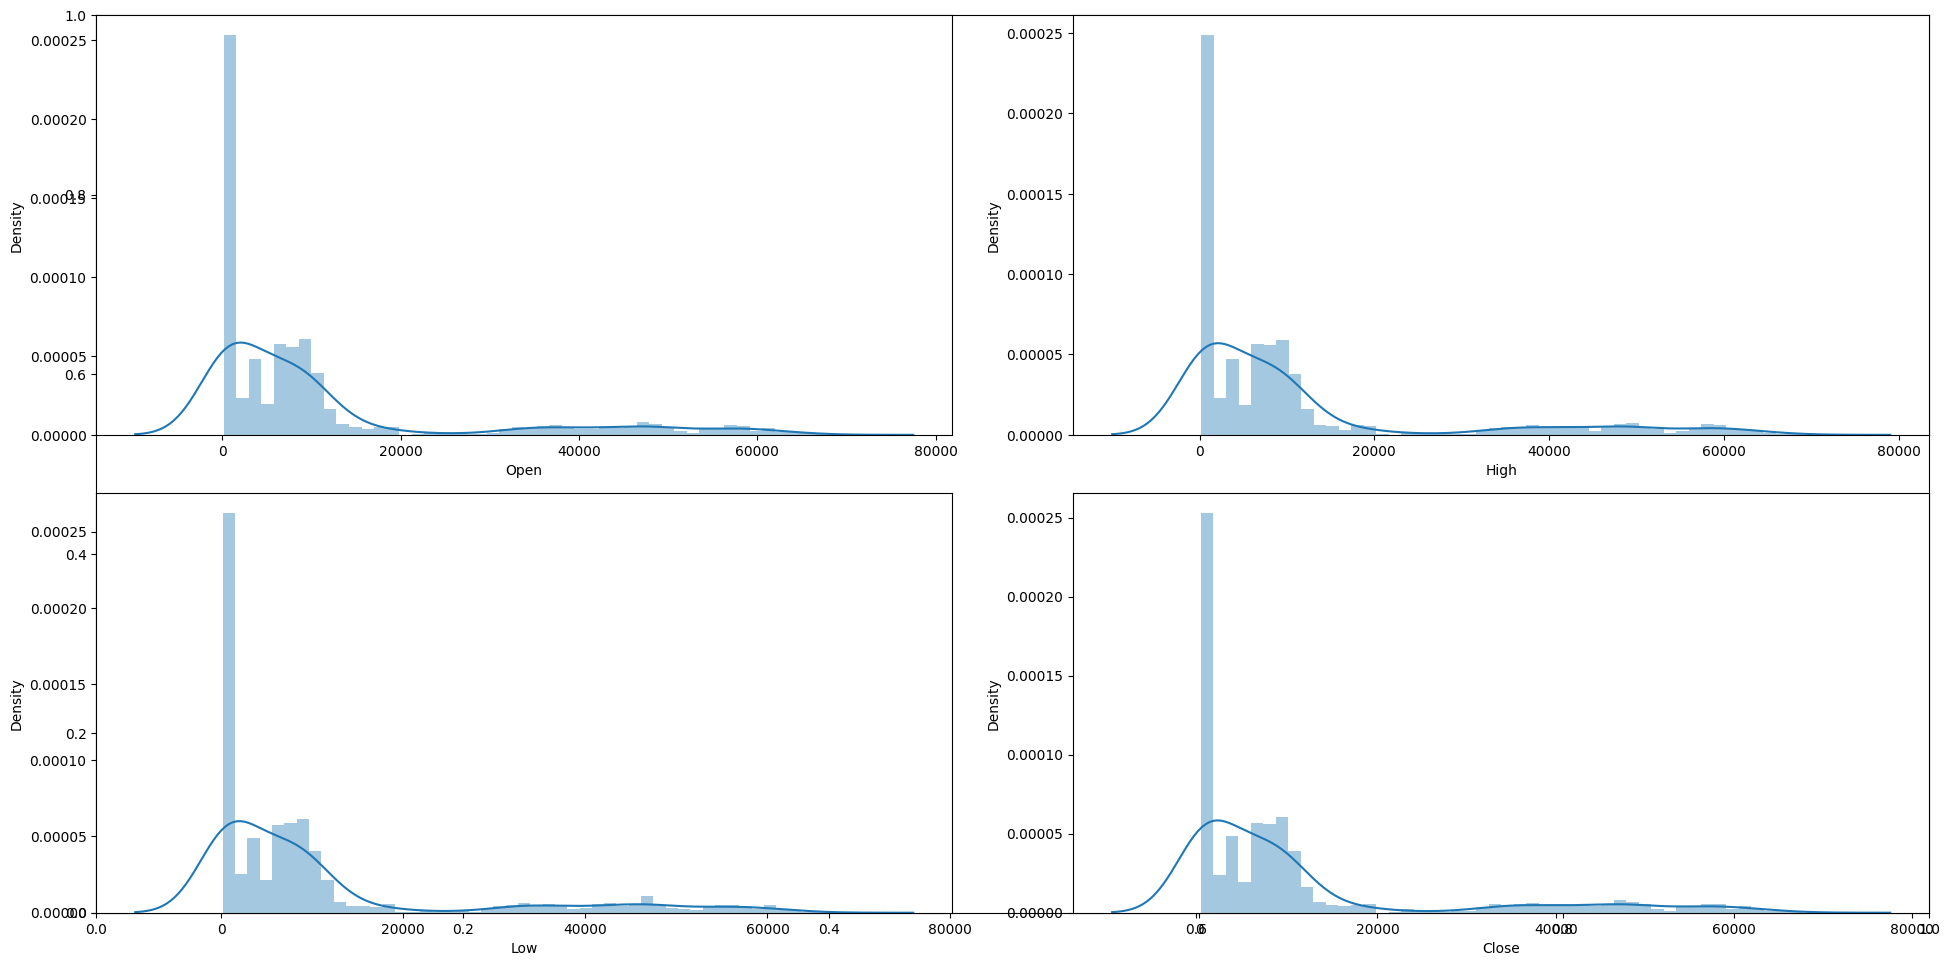

In [ ]:
features = ['Open', 'High', 'Low', 'Close']

# Convert to pandas for visualization
pdf = df.select(features).toPandas()

# Create the distribution plots
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.distplot(pdf[col])
plt.tight_layout()
plt.show()

# Feature Engineering
Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [29]:
# Even simpler: use regex to extract date parts directly
from pyspark.sql.functions import regexp_extract

# Load data with all columns as strings
df = spark.read.csv('bitcoin.csv', header=True)

# Extract date parts using regex (handles M/d/yyyy format)
df = df.withColumn("month", regexp_extract(col("Date"), r'^(\d+)/', 1).cast("int"))
df = df.withColumn("temp", regexp_extract(col("Date"), r'^(\d+/\d+)/', 1))
split_temp = split(col("temp"), "/")
df = df.withColumn("day", split_temp.getItem(1).cast("int"))
df = df.withColumn("year", regexp_extract(col("Date"), r'/(\d{4})$', 1).cast("int"))

# Convert numeric columns
for col_name in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# Create a proper date column (optional)
df = df.withColumn("Date_proper", 
                  F.concat(col("year"), F.lit("-"),
                          F.lpad(col("month"), 2, "0"), F.lit("-"),
                          F.lpad(col("day"), 2, "0")))

print("Data with extracted date parts:")
df.select("Date", "year", "month", "day", "Open", "Close").show(5)

# If you want to drop the original Date column
df = df.drop("temp", "Date_proper")

Data with extracted date parts:
+---------+----+-----+---+----------+----------+
|     Date|year|month|day|      Open|     Close|
+---------+----+-----+---+----------+----------+
|9/17/2014|2014|    9| 17|465.864014|457.334015|
|9/18/2014|2014|    9| 18|456.859985|424.440002|
|9/19/2014|2014|    9| 19|424.102997| 394.79599|
|9/20/2014|2014|    9| 20|394.673004|408.903992|
|9/21/2014|2014|    9| 21|408.084991|398.821014|
+---------+----+-----+---+----------+----------+
only showing top 5 rows



In [24]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- row_index: integer (nullable = false)



In [30]:
from pyspark.sql.functions import when

# Create is_quarter_end column
df = df.withColumn("is_quarter_end", 
                   when(col("month") % 3 == 0, 1).otherwise(0))

# Show the result
print("Data with is_quarter_end column:")
df.select("Date", "month", "is_quarter_end", "Close").show(10)

# Check distribution
print("\nQuarter end distribution:")
df.groupBy("is_quarter_end").count().show()

Data with is_quarter_end column:
+---------+-----+--------------+----------+
|     Date|month|is_quarter_end|     Close|
+---------+-----+--------------+----------+
|9/17/2014|    9|             1|457.334015|
|9/18/2014|    9|             1|424.440002|
|9/19/2014|    9|             1| 394.79599|
|9/20/2014|    9|             1|408.903992|
|9/21/2014|    9|             1|398.821014|
|9/22/2014|    9|             1|402.152008|
|9/23/2014|    9|             1|435.790985|
|9/24/2014|    9|             1|423.204987|
|9/25/2014|    9|             1|411.574005|
|9/26/2014|    9|             1|404.424988|
+---------+-----+--------------+----------+
only showing top 10 rows


Quarter end distribution:
+--------------+-----+
|is_quarter_end|count|
+--------------+-----+
|             1|  899|
|             0| 1814|
+--------------+-----+



In [31]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window

# Create open-close column
df = df.withColumn("open-close", col("Open") - col("Close"))

# Create low-high column (Note: usually it's High - Low, not Low - High)
df = df.withColumn("low-high", col("Low") - col("High"))

# Create target column using window function for shift
# Define window ordered by Date
window_spec = Window.orderBy("Date")

# Create target: 1 if next day's Close > current Close, else 0
df = df.withColumn("next_close", lag("Close", -1).over(window_spec))
df = df.withColumn("target", when(col("next_close") > col("Close"), 1).otherwise(0))

# Drop the temporary column
df = df.drop("next_close")

# Show the result
print("Data with new features and target:")
df.select("Date", "Open", "Close", "open-close", "Low", "High", "low-high", "target").show(10)

# Show target distribution
print("\nTarget value distribution:")
df.groupBy("target").count().show()

Data with new features and target:
+---------+-----------+-----------+-------------------+-----------+-----------+-------------------+------+
|     Date|       Open|      Close|         open-close|        Low|       High|           low-high|target|
+---------+-----------+-----------+-------------------+-----------+-----------+-------------------+------+
| 1/1/2015| 320.434998| 314.248993|  6.186005000000023| 314.002991| 320.434998| -6.432006999999999|     1|
| 1/1/2016| 430.721008| 434.334015|-3.6130070000000387| 427.515015| 436.246002|  -8.73098699999997|     1|
| 1/1/2017|  963.65802| 998.325012| -34.66699200000005| 958.698975|1003.080017| -44.38104199999998|     1|
| 1/1/2018| 14112.2002| 13657.2002|              455.0| 13154.7002| 14112.2002|             -957.5|     0|
| 1/1/2019|3746.713379| 3843.52002| -96.80664100000013|3707.231201|3850.913818|-143.68261699999994|     1|
| 1/1/2020| 7194.89209|7200.174316| -5.282225999999355|7174.944336|7254.330566| -79.38623000000007|     1|
| 

In [32]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Define features (note: use exact column names from your DataFrame)
# If you used hyphens, you need to handle them properly
feature_cols = ["open-close", "low-high", "is_quarter_end"]

# Check if columns exist
print("Available columns:", df.columns)
print("Selected feature columns:", feature_cols)

# 1. Create feature vector
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="raw_features"
)

# 2. Create scaler
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# 3. Split data (PySpark doesn't have train_test_split like sklearn)
# We'll use randomSplit instead
train_ratio = 0.7
test_ratio = 0.3

# First apply feature transformation
pipeline_features = Pipeline(stages=[assembler, scaler])
feature_model = pipeline_features.fit(df)
df_transformed = feature_model.transform(df)

# Split the data
train_df, test_df = df_transformed.randomSplit([train_ratio, test_ratio], seed=42)

print(f"Training samples: {train_df.count()}")
print(f"Testing samples: {test_df.count()}")
print(f"Total samples: {df_transformed.count()}")

# Show the transformed data
print("\nTransformed training data (first 5 rows):")
train_df.select("open-close", "low-high", "is_quarter_end", "target", "features").show(5)

print("\nTraining set distribution:")
train_df.groupBy("target").count().show()

print("\nTesting set distribution:")
test_df.groupBy("target").count().show()

Available columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'month', 'day', 'year', 'is_quarter_end', 'open-close', 'low-high', 'target']
Selected feature columns: ['open-close', 'low-high', 'is_quarter_end']
Training samples: 1948
Testing samples: 765
Total samples: 2713

Transformed training data (first 5 rows):
+-------------------+-------------------+--------------+------+--------------------+
|         open-close|           low-high|is_quarter_end|target|            features|
+-------------------+-------------------+--------------+------+--------------------+
|  6.186005000000023| -6.432006999999999|             0|     1|[0.02455923755624...|
|-3.6130070000000387|  -8.73098699999997|             0|     1|[0.01193270808874...|
|              455.0|             -957.5|             0|     0|[0.60287908585222...|
| -96.80664100000013|-143.68261699999994|             0|     1|[-0.1081520684054...|
| -5.282225999999355| -79.38623000000007|             0|     1|[0.

In [34]:
# 1. LOGISTIC REGRESSION MODEL (Simplest approach)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define and train model
print("Training Logistic Regression...")
lr = LogisticRegression(featuresCol="features", labelCol="target")
lr_model = lr.fit(train_df)

# Make predictions
print("\nMaking predictions...")
predictions = lr_model.transform(test_df)

# Show predictions with probability
print("\nSample predictions:")
predictions.select("target", "prediction", "probability").show(5, truncate=False)

# Evaluate model
print("\nEvaluating model...")
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
auc_score = evaluator.evaluate(predictions)
print(f"Validation AUC Score: {auc_score:.4f}")

# Check accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="target", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

Training Logistic Regression...

Making predictions...

Sample predictions:
+------+----------+----------------------------------------+
|target|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |1.0       |[0.09777387509959075,0.9022261249004092]|
|1     |1.0       |[0.32145044819543284,0.6785495518045672]|
|1     |1.0       |[0.09280848409621148,0.9071915159037885]|
|1     |1.0       |[0.09172878695430908,0.9082712130456909]|
|1     |1.0       |[0.18987938650884992,0.81012061349115]  |
+------+----------+----------------------------------------+
only showing top 5 rows


Evaluating model...
Validation AUC Score: 0.8650
Accuracy: 0.8549


In [35]:
# 2. RANDOM FOREST CLASSIFIER
from pyspark.ml.classification import RandomForestClassifier

print("\n" + "="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)

# Define and train Random Forest
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="target",
    numTrees=100,           # Number of trees in the forest
    maxDepth=10,           # Maximum depth of each tree
    seed=42                # For reproducibility
)

print("\nTraining Random Forest...")
rf_model = rf.fit(train_df)

# Make predictions
rf_predictions = rf_model.transform(test_df)

# Show predictions
print("\nSample predictions:")
rf_predictions.select("target", "prediction", "probability").show(5, truncate=False)

# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
rf_auc = evaluator.evaluate(rf_predictions)
print(f"\nValidation AUC Score: {rf_auc:.4f}")

# Show feature importance
print("\nTop 10 Feature Importances:")
feature_importance = rf_model.featureImportances
importance_list = list(zip(feature_cols, feature_importance))
importance_list.sort(key=lambda x: x[1], reverse=True)

for feature, importance in importance_list[:10]:
    print(f"  {feature}: {importance:.4f}")


RANDOM FOREST CLASSIFIER

Training Random Forest...

Sample predictions:
+------+----------+-----------------------------------------+
|target|prediction|probability                              |
+------+----------+-----------------------------------------+
|1     |1.0       |[0.042058929553023004,0.957941070446977] |
|1     |0.0       |[0.7475931519781516,0.2524068480218483]  |
|1     |1.0       |[0.11023655474953607,0.889763445250464]  |
|1     |1.0       |[0.054748396464208225,0.9452516035357919]|
|1     |1.0       |[0.29979983719644837,0.7002001628035516] |
+------+----------+-----------------------------------------+
only showing top 5 rows


Validation AUC Score: 0.8805

Top 10 Feature Importances:
  low-high: 0.7470
  open-close: 0.2259
  is_quarter_end: 0.0271


In [36]:
# 3. GRADIENT BOOSTED TREES (GBT) - Similar to XGBoost
from pyspark.ml.classification import GBTClassifier

print("\n" + "="*60)
print("GRADIENT BOOSTED TREES CLASSIFIER")
print("="*60)

# Define and train GBT
gbt = GBTClassifier(
    featuresCol="features", 
    labelCol="target",
    maxIter=100,           # Number of boosting iterations
    maxDepth=5,            # Maximum depth of each tree
    stepSize=0.1,          # Learning rate
    seed=42
)

print("\nTraining Gradient Boosted Trees...")
gbt_model = gbt.fit(train_df)

# Make predictions
gbt_predictions = gbt_model.transform(test_df)

# Show predictions
print("\nSample predictions:")
gbt_predictions.select("target", "prediction", "probability").show(5, truncate=False)

# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"\nValidation AUC Score: {gbt_auc:.4f}")

# Show feature importance
print("\nTop 10 Feature Importances:")
gbt_feature_importance = gbt_model.featureImportances
gbt_importance_list = list(zip(feature_cols, gbt_feature_importance))
gbt_importance_list.sort(key=lambda x: x[1], reverse=True)

for feature, importance in gbt_importance_list[:10]:
    print(f"  {feature}: {importance:.4f}")


GRADIENT BOOSTED TREES CLASSIFIER

Training Gradient Boosted Trees...

Sample predictions:
+------+----------+----------------------------------------+
|target|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |1.0       |[0.03993867718744828,0.9600613228125517]|
|1     |0.0       |[0.9054898484969858,0.09451015150301423]|
|1     |1.0       |[0.1093057093237011,0.8906942906762989] |
|1     |1.0       |[0.03984610708951821,0.9601538929104818]|
|1     |1.0       |[0.3811862203242227,0.6188137796757773] |
+------+----------+----------------------------------------+
only showing top 5 rows


Validation AUC Score: 0.8684

Top 10 Feature Importances:
  low-high: 0.6201
  open-close: 0.3014
  is_quarter_end: 0.0785


In [37]:
# 4. DECISION TREE CLASSIFIER (Simple tree-based model)
from pyspark.ml.classification import DecisionTreeClassifier

print("\n" + "="*60)
print("DECISION TREE CLASSIFIER")
print("="*60)

# Define and train Decision Tree
dt = DecisionTreeClassifier(
    featuresCol="features", 
    labelCol="target",
    maxDepth=10,           # Maximum depth of the tree
    minInstancesPerNode=5, # Minimum instances in a node to split
    seed=42
)

print("\nTraining Decision Tree...")
dt_model = dt.fit(train_df)

# Make predictions
dt_predictions = dt_model.transform(test_df)

# Show predictions
print("\nSample predictions:")
dt_predictions.select("target", "prediction", "probability").show(5, truncate=False)

# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
dt_auc = evaluator.evaluate(dt_predictions)
print(f"\nValidation AUC Score: {dt_auc:.4f}")

# Show the tree structure
print("\nDecision Tree depth:", dt_model.depth)
print("Decision Tree number of nodes:", dt_model.numNodes)


DECISION TREE CLASSIFIER

Training Decision Tree...

Sample predictions:
+------+----------+----------------------------------------+
|target|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |1.0       |[0.05098684210526316,0.9490131578947368]|
|1     |0.0       |[0.5555555555555556,0.4444444444444444] |
|1     |1.0       |[0.1485148514851485,0.8514851485148515] |
|1     |1.0       |[0.05,0.95]                             |
|1     |1.0       |[0.21568627450980393,0.7843137254901961]|
+------+----------+----------------------------------------+
only showing top 5 rows


Validation AUC Score: 0.8267

Decision Tree depth: 10
Decision Tree number of nodes: 65


In [40]:
# COMPARE ALL MODELS
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

models_summary = [
    ("Logistic Regression", lr_model, predictions),
    ("Random Forest", rf_model, rf_predictions),
    ("Gradient Boosted Trees", gbt_model, gbt_predictions),
    ("Decision Tree", dt_model, dt_predictions)
]

# Create evaluators
auc_evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
acc_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")

print(f"\n{'Model':<25} {'AUC':<10} {'Accuracy':<10}")
print("-" * 45)

for name, model, pred in models_summary:
    auc_score = auc_evaluator.evaluate(pred)
    accuracy = acc_evaluator.evaluate(pred)
    print(f"{name:<25} {auc_score:<10.4f} {accuracy:<10.4f}")




MODEL COMPARISON SUMMARY

Model                     AUC        Accuracy  
---------------------------------------------
Logistic Regression       0.8650     0.8549    
Random Forest             0.8805     0.8680    
Gradient Boosted Trees    0.8684     0.8575    
Decision Tree             0.8267     0.8510    
